In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split

### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

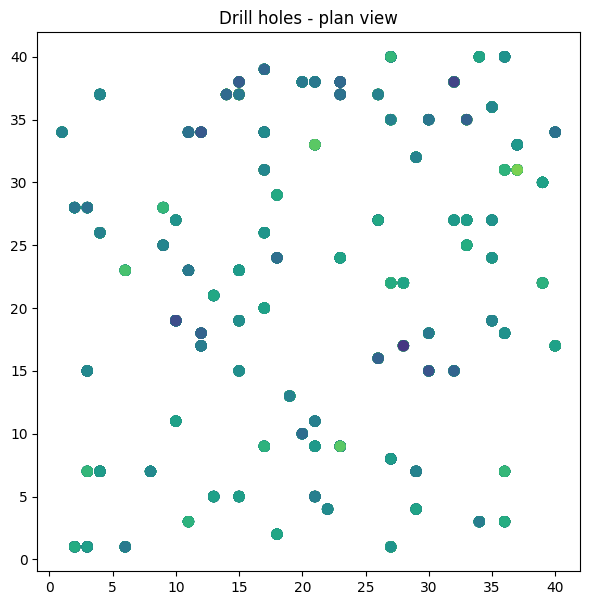

In [13]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 100

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])

fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

### Creating a Multilayer perceptron to make predictions

#### Create Training Dataset

In [14]:
df_sample = pd.get_dummies(df_simulation_sample)
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

In [61]:
# Define la clase de la red neuronal
class MineralPredictionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MineralPredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, int(hidden_size/2))
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int(hidden_size/2), hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        # self.fc4 = nn.Linear(2*hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        return out

class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  def __len__(self) -> int:
    return self.len

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train_loader = Data(X_train, y_train,device)
val_loader = Data(X_val, y_val,device)
real_loader = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

input_size = X.shape[1]  # 3 coordenadas XYZ y n_litologies litologías
hidden_size = 32
output_size = 1  # Ley mineral del yacimiento

# Inicializa la red neuronal
model = MineralPredictionNet(input_size, hidden_size, output_size)
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
# Repite el proceso de entrenamiento y validación varias veces
epochs = 20
for epoch in range(epochs):
    # Itera a través de los datos de entrenamiento
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        
        # Predice la salida usando la red neuronal
        y_pred = model(x)
        # print("target_size: ",y_pred.shape)
        # print("other: ",y.shape)
        # print("target value: ",y_pred)
        # print("other value: ",y)

        # Calcula la pérdida
        loss = criterion(y_pred, y)

        # Realiza el backpropagation y actualiza los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Itera a través de los datos de validación
    for i, (x, y) in enumerate(val_loader):
        # Convierte los datos a tensores de PyTorch
        x = torch.Tensor(x)
        y = torch.Tensor(y)

        # Predice la salida usando la red neuronal
        y_pred = model(x)

        # Calcula la pérdida
        loss = criterion(y_pred, y)
    
      # display statistics
    print(f'epoch {epoch + 1}, loss {loss:f}')

epoch 1, loss 0.000300
epoch 2, loss 0.002007
epoch 3, loss 0.005114
epoch 4, loss 0.001759
epoch 5, loss 0.000158
epoch 6, loss 0.000015
epoch 7, loss 0.000107
epoch 8, loss 0.000074
epoch 9, loss 0.000000
epoch 10, loss 0.000042
epoch 11, loss 0.000001
epoch 12, loss 0.000003
epoch 13, loss 0.000001
epoch 14, loss 0.000112
epoch 15, loss 0.000022
epoch 16, loss 0.000051
epoch 17, loss 0.000018
epoch 18, loss 0.000039
epoch 19, loss 0.000214
epoch 20, loss 0.000019


In [67]:
y_pred = []
y_real = []
for i, (x,y) in enumerate(real_loader):
    y_p = model(x)
    y_pred.append(y_p.item())
    y_real.append(y.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))

r2:  -19.49296622233237
mae:  4.370663700934907
mape:  119724503466.98183
